# Weather Forecasting Using ARIMA

This example uses the ARIMA model to forecast mean temperature for Dublin Airport from November 1941 to January 2018 using monthly weather data from the Irish weather broadcaster [Met Éireann](https://www.met.ie/climate/available-data/historical-data). The below analysis is solely that of the author and is not endorsed by or affiliated with Met Éireann in any way

#### Attributions

The below code uses the [statsmodels](https://github.com/statsmodels/statsmodels/blob/main/LICENSE.txt) library (2009-2018 statsmodels Developers) in executing the below examples, as provided under the BSD 3-Clause License.

Modifications have been made where appropriate for conducting analysis on the data specific to this example.

The copyright and permission notices are made available below:

Copyright (C) 2006, Jonathan E. Taylor
All rights reserved.

Copyright (c) 2006-2008 Scipy Developers.
All rights reserved.

Copyright (c) 2009-2018 statsmodels Developers.
All rights reserved.


Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

  a. Redistributions of source code must retain the above copyright notice,
     this list of conditions and the following disclaimer.
  b. Redistributions in binary form must reproduce the above copyright
     notice, this list of conditions and the following disclaimer in the
     documentation and/or other materials provided with the distribution.
  c. Neither the name of statsmodels nor the names of its contributors
     may be used to endorse or promote products derived from this software
     without specific prior written permission.


THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
ARE DISCLAIMED. IN NO EVENT SHALL STATSMODELS OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT
LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY
OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH
DAMAGE.

In [38]:
from platform import python_version
print(python_version())

3.8.10


In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# fix random seed for reproducibility
np.random.seed(7)

# load dataset
df = pd.read_csv('mly532.csv', engine='python', skipfooter=3)
df

,date,meant,maxtp,mintp,mnmax,mnmin,rain,gmin,wdsp,maxgt,sun
0,1941-11-01,6.9,14.0,-3.1,9.9,3.9,67.2,-5.7,12.0,,56.1
1,1941-12-01,6.5,12.7,-3.6,9.1,3.9,41.7,-7.6,12.5,,46.1
2,1942-01-01,4.3,11.9,-3.1,6.9,1.7,91.9,-9.5,13.1,,72.8
3,1942-02-01,2.9,11.6,-4.3,5.8,0.0,25.8,-10.7,9.0,,51.4
4,1942-03-01,6.3,16.2,-6.1,9.4,3.2,76.4,-8.3,10.7,,73.9
...,...,...,...,...,...,...,...,...,...,...,...
907,2017-06-01,14.4,26.3,3.7,18.6,10.2,86.4,1.6,11.0,41,161.5
908,2017-07-01,15.0,24.2,6.0,19.5,10.5,42.2,1.8,9.8,36,166.0
909,2017-08-01,14.6,21.8,4.9,18.7,10.5,73.2,0.8,10.0,31,120.5
910,2017-09-01,12.4,18.9,4.5,16.5,8.3,82.3,0.4,10.9,43,128.7


In [2]:
meant=df['meant']
meant

0       6.9
1       6.5
2       4.3
3       2.9
4       6.3
       ... 
907    14.4
908    15.0
909    14.6
910    12.4
911    11.2
Name: meant, Length: 912, dtype: float64

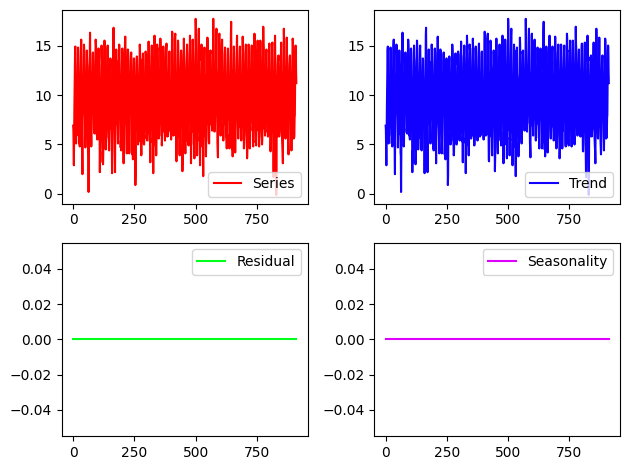

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(meant, model='additive', period=1)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.subplot(221)
plt.plot(meant,color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend,color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual,color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal,color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

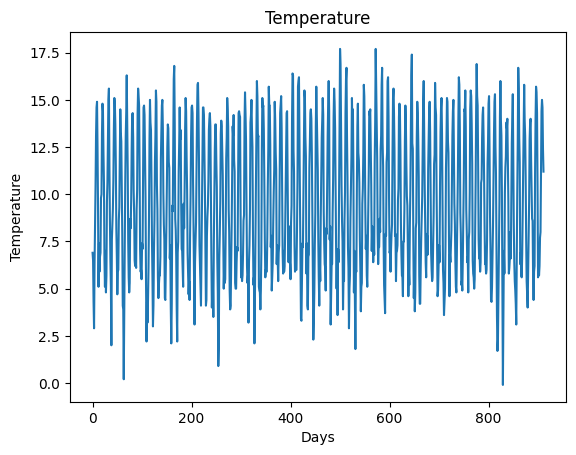

In [4]:
plt.plot(meant)
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.title("Temperature")
plt.show()

In [7]:
train_df=meant[:729]
train_df

0       6.9
1       6.5
2       4.3
3       2.9
4       6.3
       ... 
724     7.2
725     8.1
726    10.9
727    13.1
728    14.4
Name: meant, Length: 729, dtype: float64

In [8]:
#Dickey-Fuller Test
result = ts.adfuller(train_df, 1)
result

(-15.449946061180277,
 2.7927077143555687e-28,
 1,
 727,
 {'1%': -3.439376877165393,
  '5%': -2.865523768488869,
  '10%': -2.5688914082860164},
 2999.791767516566)

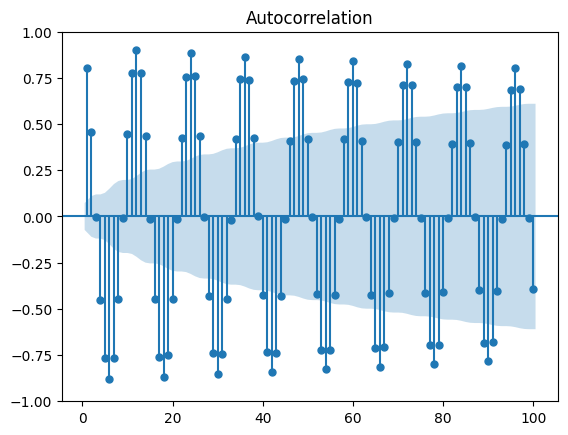

In [9]:
plot_acf(train_df, lags=100, zero=False);

/home/michael/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


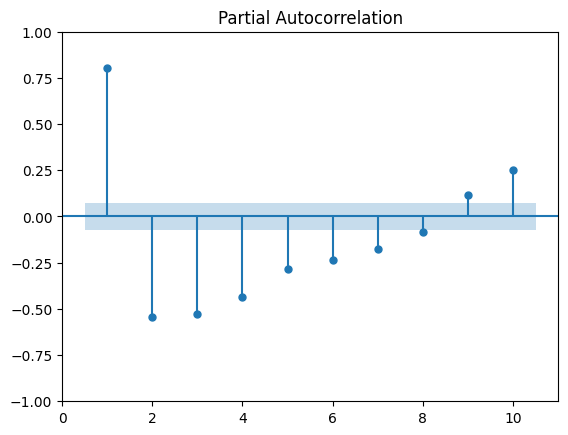

In [10]:
plot_pacf(train_df, lags=10, zero=False);

In [14]:
test_df=meant[730:912]
test_df

730    12.5
731     9.5
732     8.4
733     6.4
734     5.1
       ... 
907    14.4
908    15.0
909    14.6
910    12.4
911    11.2
Name: meant, Length: 182, dtype: float64

In [15]:
#Dickey-Fuller Test
result = ts.adfuller(train_df, 1)
result

(-15.449946061180277,
 2.7927077143555687e-28,
 1,
 727,
 {'1%': -3.439376877165393,
  '5%': -2.865523768488869,
  '10%': -2.5688914082860164},
 2999.791767516566)

In [16]:
model=sm.tsa.statespace.sarimax.SARIMAX(endog=train_df,order=(1,0,0),seasonal_order=(2,1,0,12),trend='c',enforce_invertibility=False)
results=model.fit()
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67324D+00    |proj g|=  2.01639D-01

At iterate    5    f=  1.63837D+00    |proj g|=  5.55181D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   1.612D-05   1.638D+00
  F =   1.6383663316064476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                           

In [25]:
predictions=results.predict(731, 912, typ='levels')

In [26]:
len(predictions)

182

In [27]:
predictions

731    10.613452
732     7.138680
733     4.836093
734     5.127470
735     5.610265
         ...    
908    14.700914
909    14.851564
910    13.172990
911    10.960564
912     7.207968
Name: predicted_mean, Length: 182, dtype: float64

In [28]:
len(predictions)

182

In [29]:
len(test_df)

182

In [37]:
mse=sm.tools.eval_measures.mse(test_df, predictions, axis=0)
mse
rmse=math.sqrt(mse)
rmse

2.220164167674744

In [31]:
np.mean(test_df)

9.63901098901099

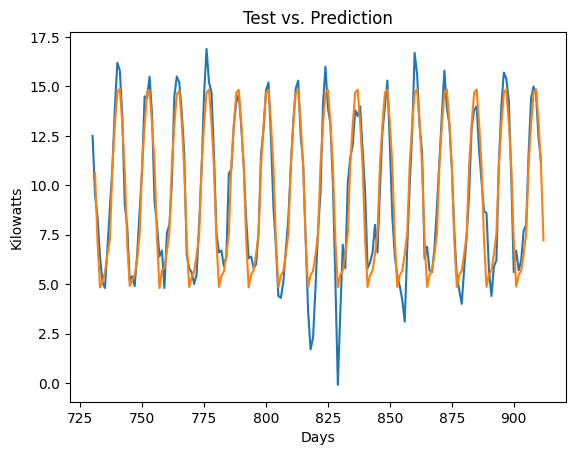

In [32]:
plt.plot(test_df)
plt.plot(predictions)
plt.xlabel('Days')
plt.ylabel('Kilowatts')
plt.title("Test vs. Prediction")
plt.show()